In [1]:
import torch

# A subset of VOCDataLoader just for one class (person) (0)
from utils.dataloader import VOCDataLoaderPerson

loader = VOCDataLoaderPerson(train=True, batch_size=128, shuffle=True)
loader_test = VOCDataLoaderPerson(train=False, batch_size=1)

In [2]:
from tinyyolov2 import TinyYoloV2
from utils.loss import YoloLoss
import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)
# We define a tinyyolo network with only two possible classes
net = TinyYoloV2(num_classes=1)
sd = torch.load("voc_pretrained.pt", map_location=device)

#We load all parameters from the pretrained dict except for the last layer
net.load_state_dict({k: v for k, v in sd.items() if not '9' in k}, strict=False)
net.eval()

net.to(device)

# Definition of the loss
criterion = YoloLoss(anchors=net.anchors)

#We only train the last layer (conv9)
for key, param in net.named_parameters():
    if any(x in key for x in ['1', '2', '3', '4', '5', '6', '7']):
        param.requires_grad = False

optimizer = torch.optim.Adam(filter(lambda x: x.requires_grad, net.parameters()), lr=0.001, weight_decay=0.0005)

cuda


In [ ]:
import numpy as np

from utils.ap import precision_recall_levels, ap, display_roc
from utils.yolo import nms, filter_boxes

NUM_TEST_SAMPLES = 200
NUM_EPOCHS = 100
test_AP = []
avg_train_losses = []
avg_test_losses = []
early_stopping_counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    if epoch >= 0:
        net.train()
        net.to(device)
        train_running_loss = 0.0
        print("Training started------------")
        for idx, (input, target) in tqdm.tqdm(enumerate(loader), total=len(loader)):
            input = input.to(device)
            target = target.to(device)
            optimizer.zero_grad()

            #Yolo head is implemented in the loss for training, therefore yolo=False
            output = net(input, yolo=False)
            loss, _ = criterion(output, target)
            train_running_loss += loss.item()
            
            loss.backward()
            optimizer.step()

    avg_train_losses.append(train_running_loss / (idx + 1))
    
    test_precision = []
    test_recall = []
    test_running_loss = 0.0
    
    net.eval()
    print("Validation started---------")
    with torch.no_grad():
        for idx, (input, target) in tqdm.tqdm(enumerate(loader_test), total=NUM_TEST_SAMPLES):
            input = input.to(device)
            target = target.to(device)
            yolo_output = net(input, yolo=True)
            
            output = net(input, yolo=False)
            test_loss, _ = criterion(output, target)
            test_running_loss += test_loss.item()
            
            #The right threshold values can be adjusted for the target application
            filtered_output = filter_boxes(yolo_output, 0.3)
            nms_output = nms(filtered_output, 0.5)
            
            precision, recall = precision_recall_levels(target[0], nms_output[0])
            test_precision.append(precision)
            test_recall.append(recall)
            
            if idx == NUM_TEST_SAMPLES:
                break
    
    avg_test_losses.append(test_running_loss / (idx + 1))
    
    print('average train losses', avg_train_losses[-1])
    print('average test losses', avg_test_losses[-1])
    
    print('test precision', np.mean(test_precision))
    print('test recall', np.mean(test_recall))
    
    #Calculation of average precision with collected samples
    test_AP.append(ap(test_precision, test_recall))
    print('average precision', test_AP)
    
    
    #early stopping
    if epoch > 0 and abs(avg_test_losses[epoch] - avg_test_losses[epoch-1]) < 0.002:
        early_stopping_counter +=1
        if early_stopping_counter >5:
            print("*************early stopping*************")
            torch.save(net.state_dict(), f"models/voc_finetuned_{epoch+1}_epochs_lr0001_decay0005.pt")
            break
    else:
       early_stopping_counter = 0 
    
    if (epoch + 1) % 5 == 0:
        display_roc(test_precision, test_recall)
        
    if (epoch + 1) % 5 == 0:
        torch.save(net.state_dict(), f"models/voc_finetuned_{epoch+1}_epochs_lr0001_decay0005.pt")
    
net.to("cpu")
state_dict = net.state_dict()
torch.save(state_dict, 'models/voc_finetuned_100_epochs_lr0001_decay0005.pt')

In [20]:
import torch
# A subset of VOCDataLoader just for one class (person) (0)
from utils.dataloader import VOCDataLoaderPerson
loader = VOCDataLoaderPerson(train=True, batch_size=128, shuffle=True)
loader_test = VOCDataLoaderPerson(train=False, batch_size=1)

from tinyyolov2 import TinyYoloV2
from utils.loss import YoloLoss
import tqdm
import numpy as np
from utils.ap import precision_recall_levels, ap, display_roc
from utils.yolo import nms, filter_boxes
import matplotlib.pyplot as plt

def validateCkptFile(model_with_state_dict, output_image_name):
    NUM_TEST_SAMPLES = 200
    test_AP = []
    avg_test_losses = []
    test_precision = []
    test_recall = []
    test_running_loss = 0.0

    print("Validation started---------")

    with torch.no_grad():
        for idx, (input, target) in tqdm.tqdm(enumerate(loader_test), total=NUM_TEST_SAMPLES):
            input = input.to(device)
            target = target.to(device)
            yolo_output = model_with_state_dict(input, yolo=True)
            
            output = model_with_state_dict(input, yolo=False)
            test_loss, _ = criterion(output, target)
            test_running_loss += test_loss.item()
            
            #The right threshold values can be adjusted for the target application
            filtered_output = filter_boxes(yolo_output, 0.3)
            nms_output = nms(filtered_output, 0.5)
            
            precision, recall = precision_recall_levels(target[0], nms_output[0])
            test_precision.append(precision)
            test_recall.append(recall)
            
            if idx == NUM_TEST_SAMPLES:
                break
    
    avg_test_losses.append(test_running_loss / (idx + 1))
    
    print('average train losses', avg_train_losses[-1])
    print('average test losses', avg_test_losses[-1])
    
    print('test precision', np.mean(test_precision))
    print('test recall', np.mean(test_recall))
    
    #Calculation of average precision with collected samples
    test_AP.append(ap(test_precision, test_recall))
    print('average precision', test_AP)

    # display_roc(test_precision, test_recall)

    recall = np.mean(np.array(test_recall), axis=0)
    precision = np.mean(np.array(test_precision), axis=0)

    plt.plot(recall, precision)
    plt.xlim((0,1.1))
    plt.ylim((0,1.1))
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('precision over recall')

    # plt.savefig(f"plot/{output_image_name}.png")
    
    plt.show()



Validation started---------


  1%|          | 2/200 [00:00<00:14, 13.49it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


  3%|▎         | 6/200 [00:00<00:11, 16.81it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


  5%|▌         | 10/200 [00:00<00:11, 16.60it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


  7%|▋         | 14/200 [00:00<00:09, 19.99it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 11%|█         | 22/200 [00:01<00:07, 22.30it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 14%|█▍        | 28/200 [00:01<00:07, 23.15it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 16%|█▌        | 31/200 [00:01<00:07, 23.05it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 17%|█▋        | 34/200 [00:01<00:07, 21.14it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 20%|█▉        | 39/200 [00:02<00:13, 12.20it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 20%|██        | 41/200 [00:02<00:12, 13.16it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 24%|██▍       | 48/200 [00:02<00:07, 19.48it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 28%|██▊       | 55/200 [00:03<00:08, 16.88it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 29%|██▉       | 58/200 [00:03<00:08, 16.12it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 30%|███       | 60/200 [00:03<00:08, 15.76it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 33%|███▎      | 66/200 [00:03<00:06, 19.57it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 35%|███▌      | 70/200 [00:04<00:06, 19.33it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 38%|███▊      | 77/200 [00:04<00:06, 19.37it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 42%|████▏     | 83/200 [00:04<00:06, 18.38it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 45%|████▌     | 90/200 [00:05<00:04, 22.87it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 48%|████▊     | 97/200 [00:05<00:03, 26.06it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 52%|█████▏    | 104/200 [00:05<00:04, 19.57it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 55%|█████▌    | 110/200 [00:05<00:04, 21.56it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 58%|█████▊    | 116/200 [00:06<00:03, 22.59it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 61%|██████    | 122/200 [00:06<00:04, 18.41it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 62%|██████▎   | 125/200 [00:07<00:06, 12.23it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 64%|██████▍   | 128/200 [00:07<00:05, 13.31it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 65%|██████▌   | 130/200 [00:07<00:09,  7.75it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 66%|██████▌   | 132/200 [00:08<00:10,  6.65it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 68%|██████▊   | 135/200 [00:08<00:08,  7.30it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 68%|██████▊   | 136/200 [00:08<00:08,  7.64it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 70%|███████   | 140/200 [00:09<00:06,  9.15it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 72%|███████▎  | 145/200 [00:09<00:04, 12.82it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 74%|███████▎  | 147/200 [00:09<00:03, 14.12it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 76%|███████▌  | 152/200 [00:09<00:03, 14.37it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 80%|███████▉  | 159/200 [00:10<00:01, 21.71it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 82%|████████▏ | 164/200 [00:10<00:03, 11.45it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 83%|████████▎ | 166/200 [00:11<00:03,  8.87it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 86%|████████▋ | 173/200 [00:11<00:01, 15.25it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 88%|████████▊ | 176/200 [00:11<00:01, 16.69it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 91%|█████████ | 182/200 [00:11<00:00, 18.89it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 94%|█████████▍| 189/200 [00:12<00:00, 21.16it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 98%|█████████▊| 195/200 [00:12<00:00, 20.12it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


100%|██████████| 200/200 [00:12<00:00, 15.66it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
average train losses 0.2478819761206122
average test losses 1.8448496388076847
test precision 0.8192533005965842
test recall 0.36565979625681116
average precision [0.4819409446275118]


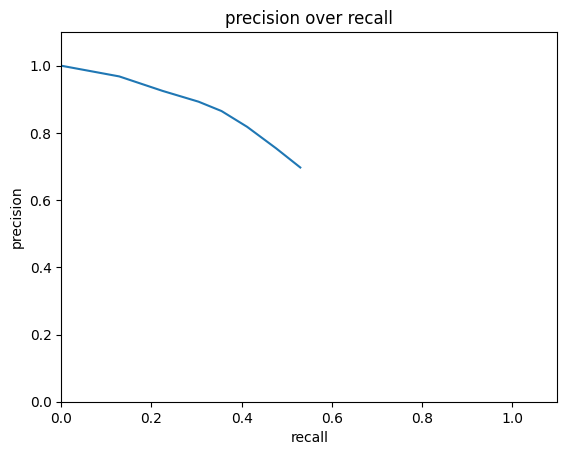

Validation started---------


  2%|▏         | 4/200 [00:00<00:06, 28.09it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


  4%|▎         | 7/200 [00:00<00:06, 27.72it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


  7%|▋         | 14/200 [00:00<00:09, 19.16it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


  8%|▊         | 17/200 [00:00<00:08, 20.79it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 12%|█▏        | 23/200 [00:01<00:08, 19.78it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 14%|█▍        | 29/200 [00:01<00:08, 20.80it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 16%|█▌        | 32/200 [00:01<00:09, 18.49it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 19%|█▉        | 38/200 [00:02<00:12, 12.87it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 21%|██        | 42/200 [00:02<00:11, 13.82it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 24%|██▎       | 47/200 [00:02<00:09, 16.80it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 26%|██▋       | 53/200 [00:03<00:09, 15.76it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 28%|██▊       | 56/200 [00:03<00:11, 13.03it/s]

torch.Size([1, 30, 10, 10])


 30%|██▉       | 59/200 [00:03<00:09, 15.07it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 32%|███▏      | 63/200 [00:03<00:09, 14.41it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 34%|███▎      | 67/200 [00:04<00:06, 19.05it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 35%|███▌      | 70/200 [00:04<00:07, 17.22it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 38%|███▊      | 75/200 [00:04<00:08, 15.62it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 39%|███▉      | 78/200 [00:04<00:07, 16.37it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 42%|████▏     | 83/200 [00:05<00:07, 16.61it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 44%|████▍     | 89/200 [00:05<00:05, 21.84it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 48%|████▊     | 96/200 [00:05<00:04, 25.67it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 50%|████▉     | 99/200 [00:05<00:03, 26.23it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 52%|█████▎    | 105/200 [00:06<00:04, 19.23it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 56%|█████▌    | 111/200 [00:06<00:04, 20.90it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 58%|█████▊    | 117/200 [00:06<00:03, 22.63it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 60%|██████    | 120/200 [00:06<00:04, 19.93it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 62%|██████▎   | 125/200 [00:07<00:07, 10.07it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 66%|██████▌   | 131/200 [00:08<00:08,  8.16it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 66%|██████▋   | 133/200 [00:09<00:10,  6.50it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 68%|██████▊   | 135/200 [00:09<00:10,  6.42it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 68%|██████▊   | 136/200 [00:09<00:09,  6.67it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 70%|███████   | 140/200 [00:10<00:07,  8.27it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 72%|███████▎  | 145/200 [00:10<00:04, 11.99it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 74%|███████▍  | 149/200 [00:10<00:03, 14.57it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 76%|███████▋  | 153/200 [00:10<00:03, 12.30it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 78%|███████▊  | 155/200 [00:11<00:03, 13.23it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 80%|███████▉  | 159/200 [00:11<00:02, 18.65it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 82%|████████▏ | 164/200 [00:12<00:03,  9.18it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 83%|████████▎ | 166/200 [00:12<00:04,  6.87it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 86%|████████▌ | 171/200 [00:12<00:02, 10.93it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 88%|████████▊ | 176/200 [00:12<00:01, 12.70it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 90%|█████████ | 180/200 [00:13<00:01, 13.78it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 92%|█████████▏| 184/200 [00:13<00:00, 18.39it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 94%|█████████▍| 189/200 [00:13<00:00, 14.77it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 96%|█████████▌| 191/200 [00:13<00:00, 13.53it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


 97%|█████████▋| 194/200 [00:14<00:00, 14.85it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])


100%|██████████| 200/200 [00:14<00:00, 13.91it/s]

torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
torch.Size([1, 30, 10, 10])
average train losses 0.2478819761206122
average test losses 1.8215011005748565
test precision 0.8366123397949561
test recall 0.4200684887252051
average precision [0.4964199564945833]


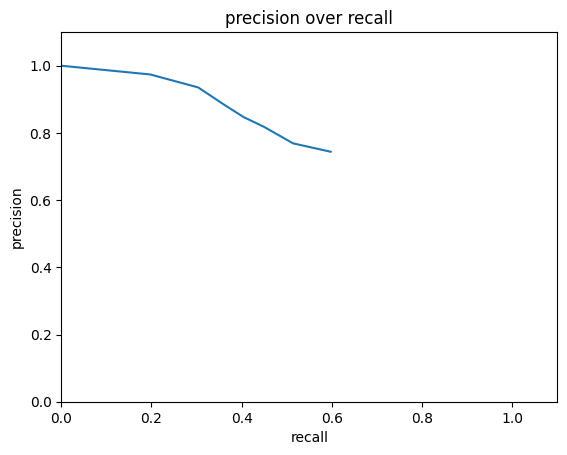

In [21]:
model = TinyYoloV2(num_classes=1)

for i in range(95, 102, 5):
    path = f"models/voc_finetuned_{i}_epochs_lr0001_decay0005.pt"
    output_image_name = f"voc_finetuned_{i}_epochs_lr0001_decay0005_roc"
    sdict = torch.load(path)
    model.load_state_dict(sdict, strict=False)
    model.eval()
    model.to(device)
    validateCkptFile(model, output_image_name)